In [1]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

Warning serial library import failed.
Warning could not load Chase AWG dll, check that dll located at 'C:\_Lib\python\slab\instruments\awg\chase\dax22000_lib_DLL32.dll'


C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\qt.py:13: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  "You should import from qtconsole instead.", ShimWarning)


Could not load InstrumentManagerWindow
Warning could not load LDA labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_atten.dll'
Warning could not load LMS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\vnx_fmsynth.dll'
Warning could not load LPS labbrick dll, check that dll located at 'C:\_Lib\python\slab\instruments\labbrick\VNX_dps.dll'
Could not load labbrick
Warning no qutip!


# Load electrostatic potential from simulation data 

In [59]:
from TrapAnalysis.solve_eom import FullSolver
from scipy.constants import hbar, m_e, elementary_charge as q_e

settings_file = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6"
settings_file += r"\With L3 etch - just trap\settings.json"
fs = FullSolver(settings_file)

x = 0.40
mu_guess = -0.265
def f_mu(mu):
    return -1.755 - 7*mu

# Vtrap = np.linspace(0.20, 0.40, 61) 
# Vrg = np.linspace(-1/1.15 * (Vtrap[0] - (f_mu(mu_guess)-0.120)) - x, 
#                   -1/1.15 * (Vtrap[-1] -(f_mu(mu_guess)-0.120)), len(Vtrap))
# Vres = 0.60 * np.ones(len(Vtrap)) 
# Vtg = 0.00 * np.ones(len(Vtrap))
# Vcg = None

x = 0.40
# mu_guess = -0.500
# def f_mu(mu):
#     return -2.86 - 6.93*mu

Vtrap = 0.31 #np.linspace(0.45, 0.70, 11) 
Vrg = -0.24 #-1/1.15 * (Vtrap - f_mu(mu_guess)) - x 
Vres = 0.60
Vtg = 0.00 
Vcg = None

print(Vres, Vtrap, Vrg, Vtg)

0.6 0.31 -0.24 0.0


In [60]:
fs.set_dc_interpolator(Vres, Vtrap, Vrg, Vtg)

In [61]:
Npts = 501

x = np.linspace(-1.5E-6, 1.5E-6, Npts)
y = np.linspace(-3E-6, 3E-6, Npts)

X, Y = np.meshgrid(x, y)

U = fs.dc_interpolator.ev(X, Y)
min_idx = np.unravel_index(np.argmin(U), np.shape(U))

print("Interpolation spacing in (x, y) direction is (%.0f nm, %.0f nm)" % (np.diff(x)[0] * 1E9, np.diff(y)[0] * 1E9))

Interpolation spacing in (x, y) direction is (6 nm, 12 nm)


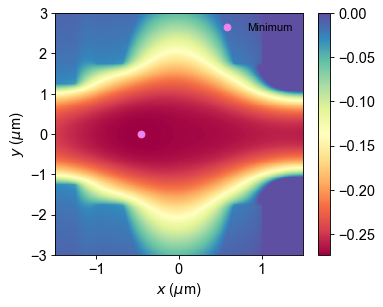

In [62]:
fig = plt.figure(figsize=(5, 4.))
common.configure_axes(13)
plt.pcolormesh(X * 1E6, Y * 1E6, U, cmap=plt.cm.Spectral, vmin=np.min(U), vmax=0.0)
plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='violet', label="Minimum")
plt.legend(loc=0, frameon=False, prop={"size" : 10})
plt.colorbar()
plt.ylabel("$y$ ($\mu$m)")
plt.xlabel("$x$ ($\mu$m)")

In [63]:
N_evals = 5

el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
el.sparsify(num_levels=N_evals)
Evals, Evecs = el.solve(sparse_args=el.sparse_args)

Psis = el.get_2Dpsis(N_evals)
mode_frequencies = (Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar)

In [64]:
print(tabulate(np.array([np.arange(N_evals), (mode_frequencies)/1E9, 
                np.append(np.zeros(1), np.diff(mode_frequencies)/1E9), 
                         [np.sum(Psis[i] * np.conjugate(Psis[i])) for i in range(N_evals)]]).T, 
               tablefmt="fancy_grid", headers=["n", "fn (GHz)", "fn - fn-1 (GHz)", "||<n|n>||"], 
               floatfmt=".3f", numalign="center", stralign='left'))

╒═══════╤════════════╤═══════════════════╤═════════════╕
│   n   │  fn (GHz)  │  fn - fn-1 (GHz)  │  ||<n|n>||  │
╞═══════╪════════════╪═══════════════════╪═════════════╡
│ 0.000 │   0.000    │       0.000       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 1.000 │   6.418    │       6.418       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 2.000 │   13.407   │       6.988       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 3.000 │   13.492   │       0.085       │    1.000    │
├───────┼────────────┼───────────────────┼─────────────┤
│ 4.000 │   19.945   │       6.453       │    1.000    │
╘═══════╧════════════╧═══════════════════╧═════════════╛


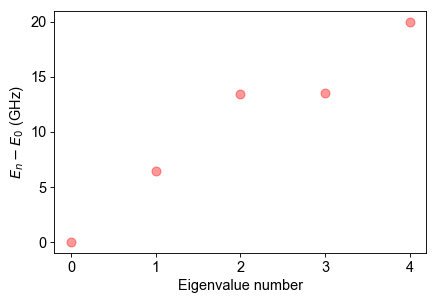

In [65]:
plt.figure()
plt.plot(mode_frequencies / 1E9, 'o', **common.plot_opt('red'))
plt.xlabel("Eigenvalue number")
plt.ylabel("$E_n - E_0$ (GHz)")

In [81]:
savepath=r"S:\Gerwin\Electron on helium\Papers\2017 - Circuit QED with a single electron on helium\Figure 4"

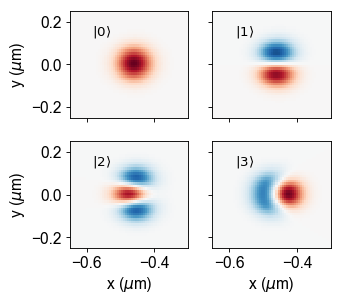

In [117]:
fig = plt.figure(figsize=(4.5, 4))
common.configure_axes(14)

for i in range(0, 4):
    max_idx = np.unravel_index(np.argmax(Psis[i]), np.shape(U))
    if i == 0:
        cmax = np.max(np.abs(Psis[i]))
        cmin = -cmax
    
    plt.subplot(2, 2, i+1)
    yeh = plt.pcolormesh(el.x * 1E6, el.y * 1E6, Psis[i], cmap=plt.cm.RdBu_r, vmin=cmin, vmax=cmax)
    if 0:
        plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='black', label="Classical minimum")
        plt.legend(loc=0, prop={"size" : 10}, frameon=False)
    
#     if i == 0:
#         plt.plot([], [], label=r"$|%d \rangle$" % i)
#     else:
#         plt.plot([], [], label=r"$|%d \rangle, f_{%d}-f_0$ = %.1f GHz" % (i, i, (mode_frequencies[i] - mode_frequencies[0])/1E9))
    plt.plot([], [], label=r"$|%d \rangle$" % i)

    leg = plt.legend(loc=2, frameon=False, prop={"size" : 12}, handlelength=0)
#     plt.title("Mode #%d | %.3f GHz" % (i, (mode_frequencies[i] - mode_frequencies[0])/1E9))
#     plt.hlines(0.0, -0.75, -0.25, linestyles='--', color='k', alpha=0.5)
    if i >= 2:
        plt.xlabel("x ($\mu$m)")
    else:
        ax = plt.gca()
        ax.axes.get_xaxis().set_ticklabels([])
    if i in [0, 2]:
        plt.ylabel("y ($\mu$m)")
    else:
        ax = plt.gca()
        ax.axes.get_yaxis().set_ticklabels([])
        
    plt.xlim(-0.65, -0.3)
    plt.ylim(-0.25, 0.25)
    
# ysize = 0.75
# xsize = 0.025
# cbar_ax = fig.add_axes([0.95, (1-ysize)/2., xsize, ysize])
# fig.colorbar(yeh, cax=cbar_ax)

fig.tight_layout()
fig.savefig(os.path.join(savepath, "007_wave_functions.png"), dpi=300)